In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Define paths to the dataset
train_dir = r"C:\Users\SABA\OneDrive\Desktop\INTERNSHIP\Dataset\Dataset\TRAINING"
val_dir = r"C:\Users\SABA\OneDrive\Desktop\INTERNSHIP\Dataset\Dataset\VALIDATION"
test_dir = r"C:\Users\SABA\OneDrive\Desktop\INTERNSHIP\Dataset\Dataset\TESTING"

In [3]:
# Image Data Generator for Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2]
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 2610 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


In [6]:
# Function to build the model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
# Build and compile models
base_models = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'VGG19': VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}
models = {}
histories = {}
for name, base_model in base_models.items():
    model = build_model(base_model)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    models[name] = model

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

In [9]:
# Train models
for name, model in models.items():
    print(f"Training {name}...")
    histories[name] = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

Training VGG16...
Epoch 1/20


C:\Users\SABA\Downloads\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 1429s 9s/step - accuracy: 0.6260 - loss: 0.6538 - val_accuracy: 0.7724 - val_loss: 0.5260 - learning_rate: 1.0000e-04
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1309s 8s/step - accuracy: 0.7441 - loss: 0.4979 - val_accuracy: 0.8171 - val_loss: 0.4212 - learning_rate: 1.0000e-04
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1315s 8s/step - accuracy: 0.7808 - loss: 0.4475 - val_accuracy: 0.8293 - val_loss: 0.3848 - learning_rate: 1.0000e-04
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1304s 8s/step - accuracy: 0.8318 - loss: 0.3742 - val_accuracy: 0.8720 - val_loss: 0.3026 - learning_rate: 1.0000e-04
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1342s 8s/step - accuracy: 0.8339 - loss: 0.3655 - val_accuracy: 0.8821 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1378s 8s/step - accuracy: 0.8684 - loss: 0.3114 - val_accuracy: 0.8333 - val_loss: 0.3453 - learning_rate: 1.0000e-04
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1301s 8s/step - accurac

In [10]:
# Function to plot accuracy and loss
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    
    plt.show()

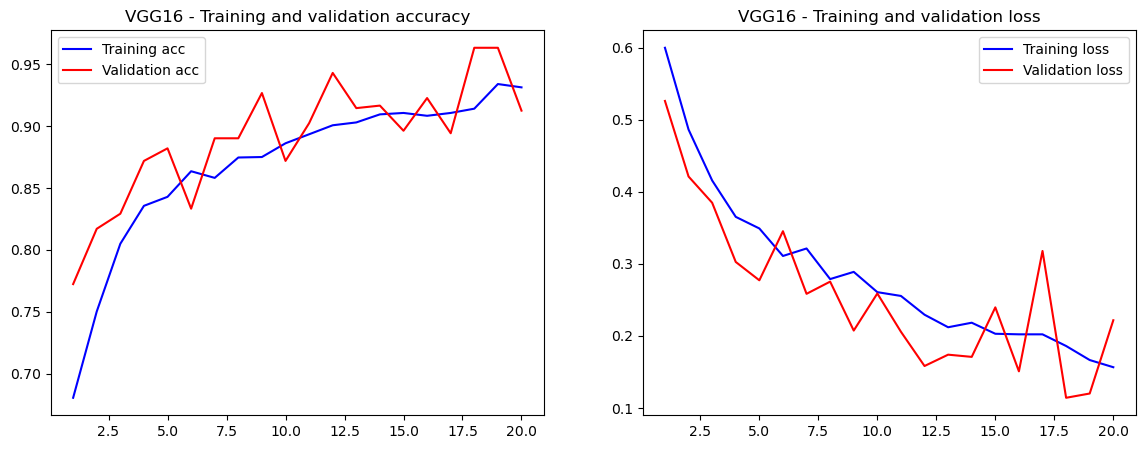

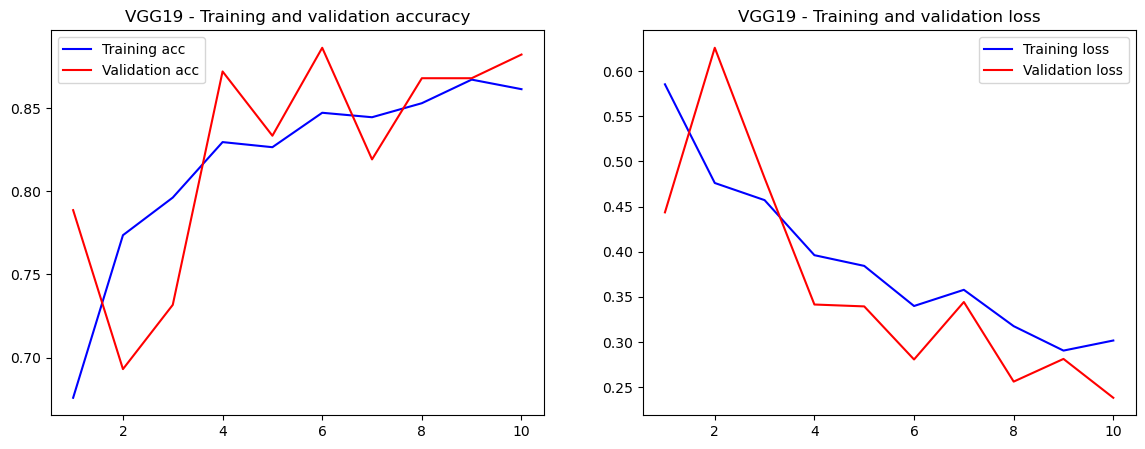

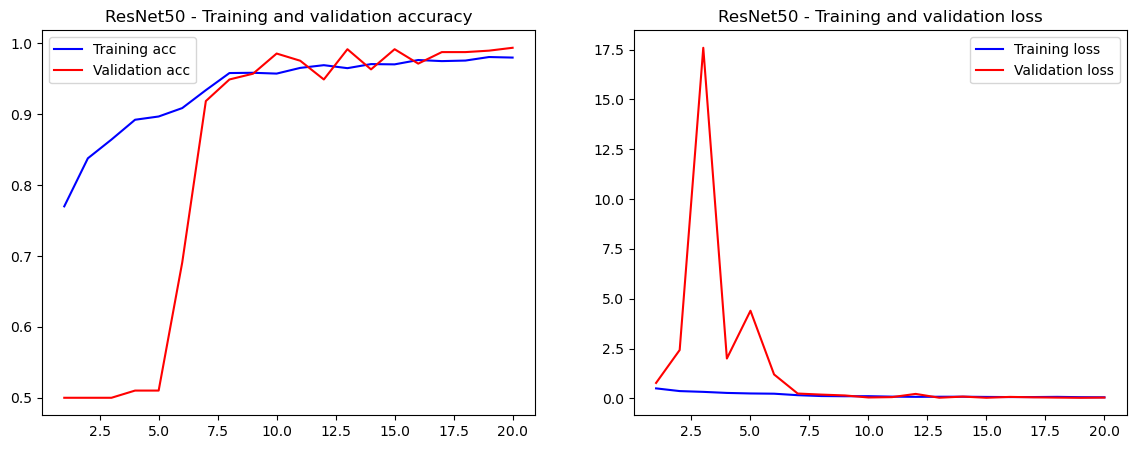

In [11]:
# Plotting the training history
for name, history in histories.items():
    plot_history(history, name)

In [12]:
# Function to generate confusion matrix and classification report
def evaluate_model(model, test_generator, title):
    test_generator.reset()
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).ravel()
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    print(f'Classification Report for {title}:')
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))
    
    cm = confusion_matrix(true_classes, predicted_classes)
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Classification Report for VGG16:
              precision    recall  f1-score   support

     Healthy       0.96      0.98      0.97        81
   Parkinson       0.97      0.96      0.97        81

    accuracy                           0.97       162
   macro avg       0.97      0.97      0.97       162
weighted avg       0.97      0.97      0.97       162



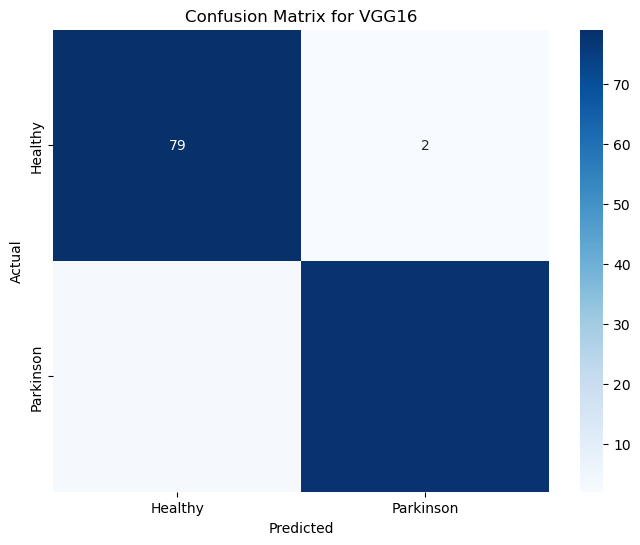

11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step
Classification Report for VGG19:
              precision    recall  f1-score   support

     Healthy       0.75      0.96      0.84        81
   Parkinson       0.95      0.68      0.79        81

    accuracy                           0.82       162
   macro avg       0.85      0.82      0.82       162
weighted avg       0.85      0.82      0.82       162



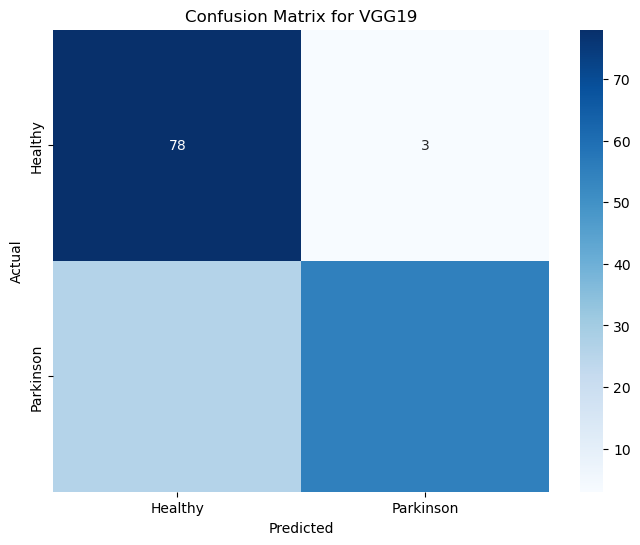

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Classification Report for ResNet50:
              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99        81
   Parkinson       1.00      0.98      0.99        81

    accuracy                           0.99       162
   macro avg       0.99      0.99      0.99       162
weighted avg       0.99      0.99      0.99       162



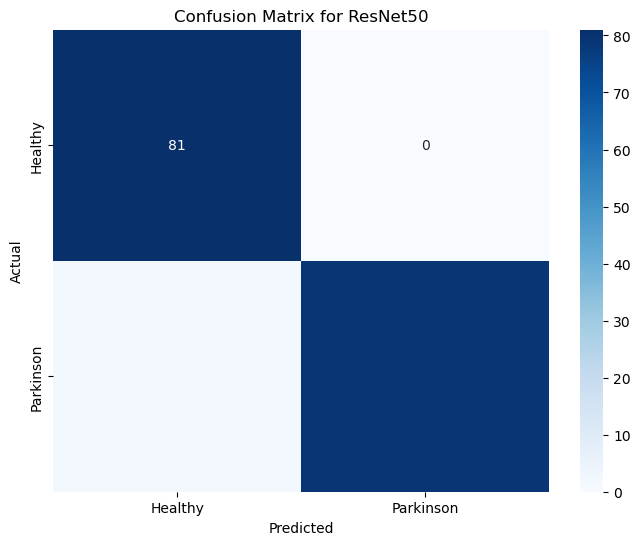

In [13]:
# Evaluating each model
for name, model in models.items():
    evaluate_model(model, test_generator, name)